In [18]:
import matplotlib.pyplot as plt
import numpy as np
import bemcs
import quadpy


def triangle_properties(vertices_array):
    """
    Compute the area of a triangle given its three vertices.

    Parameters:
    vertices (np.array): A (3, 2) array containing the coordinates of the triangle's vertices.

    Returns:
    float: The area of the triangle.
    """

    n = len(vertices_array)
    area = np.zeros(n)
    xm = np.zeros(n)
    ym = np.zeros(n)

    for i in range(0, n):
        vertices = vertices_array[i]
        x1, y1 = vertices[0]
        x2, y2 = vertices[1]
        x3, y3 = vertices[2]

        # Using the determinant formula to compute the area
        area[i] = 0.5 * abs(x1 * (y2 - y3) + x2 * (y3 - y1) + x3 * (y1 - y2))

        xm[i] = np.mean(vertices[:, 0])
        ym[i] = np.mean(vertices[:, 1])

    return xm, ym, area


# Elastic parameter (shear modulus)
mu = 1.0

# Step 1:Construct line element and triangle elements

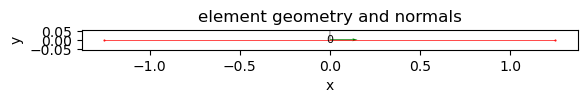

In [19]:
# construct triangle mesh
# geometry of the problem
Rx = 2.5

# construct line mesh
els = bemcs.initialize_els()

els.x1 = np.array([-Rx / 2])
els.y1 = np.array([0.0])
els.x2 = np.array([Rx / 2])
els.y2 = np.array([0.0])

bemcs.standardize_els_geometry(els, reorder=False)
n_els = len(els.x1)
bemcs.plot_els_geometry(els)

# plotting points
nx = 51
ny = 61
xvec = np.linspace(-3, 3, nx)
yvec = np.linspace(-2, 2, ny)
x_obs, y_obs = np.meshgrid(xvec, yvec)

K_sx, K_sy, K_u = bemcs.get_displacement_stress_kernel_force_antiplane(
    x_obs.flatten(), y_obs.flatten(), els, mu
)
# line force coefficients
lincoefs = np.array([[1.0, 1.0]]) / Rx

# compute displacements and stress components for line mesh (this is the benchmark)
u = np.tensordot(K_u, lincoefs, axes=([2, 1], [0, 1]))
sx = np.tensordot(K_sx, lincoefs, axes=([2, 1], [0, 1]))
sy = np.tensordot(K_sy, lincoefs, axes=([2, 1], [0, 1]))

# Vary length in y-direction of tri mesh and construct kernels

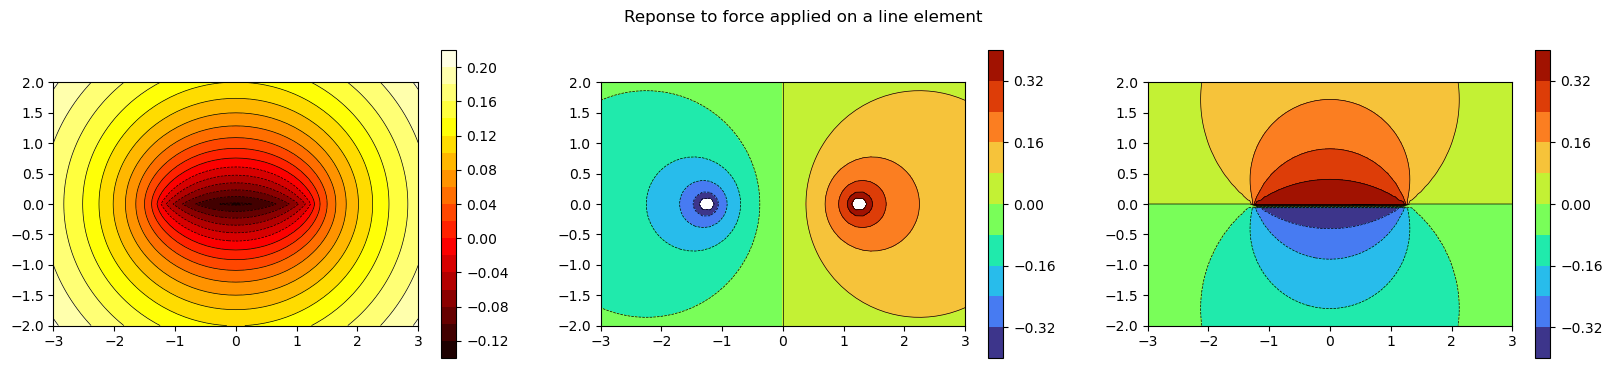

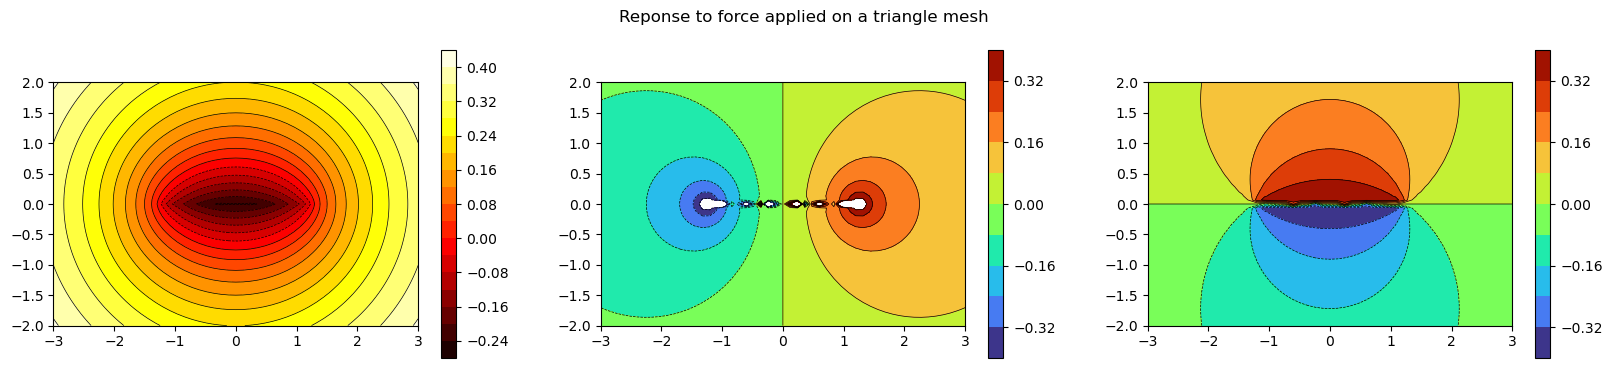

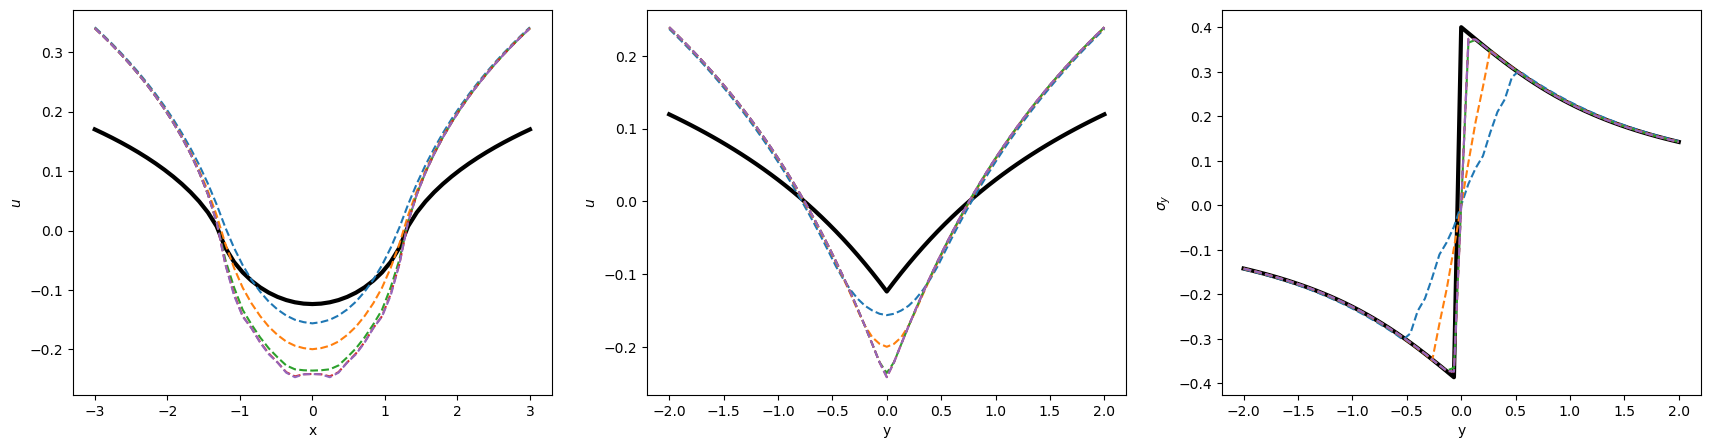

In [20]:
Ry_vec = np.array([1, 0.5, 0.1, 0.01, 0.001])
Nruns = len(Ry_vec)

u_vec = np.zeros((len(u), Nruns))
sx_vec = np.zeros_like(u_vec)
sy_vec = np.zeros_like(u_vec)

for count in range(0, Nruns):
    Ry = Ry_vec[count]

    p1 = np.array([-Rx / 2, -Ry / 2])
    p2 = np.array([Rx / 2, -Ry / 2])
    p3 = np.array([Rx / 2, Ry / 2])
    p4 = np.array([-Rx / 2, Ry / 2])
    # construct 2 triangles and compute responses
    triangle = (np.array([p1, p3, p2]), np.array([p1, p4, p3]))
    xm, ym, area = triangle_properties(triangle)

    u_tri = np.zeros(nx * ny)
    sx_tri = np.zeros(nx * ny)
    sy_tri = np.zeros(nx * ny)

    for i in range(0, 2):
        uval, sxval, syval = (
            bemcs.displacements_stresses_triangle_force_antiplane_farfield(
                triangle[i], x_obs.flatten(), y_obs.flatten()
            )
        )
        u_tri = u_tri + uval / area[i]
        sx_tri = sx_tri + sxval / area[i]
        sy_tri = sy_tri + syval / area[i]

    u_vec[:, count] = u_tri
    sx_vec[:, count] = sx_tri
    sy_vec[:, count] = sy_tri

# plot results for line element force
levels = np.linspace(-1.0 / Rx, 1.0 / Rx, 11)
plt.figure(figsize=(20, 4))
plt.subplot(1, 3, 1)
plt.contourf(x_obs, y_obs, u.reshape(ny, nx), 19, cmap="hot")
plt.colorbar()
plt.contour(x_obs, y_obs, u.reshape(ny, nx), 19, colors="k", linewidths=0.5)
plt.gca().set_aspect("equal", adjustable="box")
plt.subplot(1, 3, 2)
plt.contourf(x_obs, y_obs, sx.reshape(ny, nx), levels=levels, cmap="turbo")
plt.colorbar()
plt.contour(x_obs, y_obs, sx.reshape(ny, nx), levels=levels, colors="k", linewidths=0.5)
plt.gca().set_aspect("equal", adjustable="box")
plt.subplot(1, 3, 3)
plt.contourf(x_obs, y_obs, sy.reshape(ny, nx), levels=levels, cmap="turbo")
plt.colorbar()
plt.contour(x_obs, y_obs, sy.reshape(ny, nx), levels=levels, colors="k", linewidths=0.5)
plt.gca().set_aspect("equal", adjustable="box")
plt.suptitle("Reponse to force applied on a line element")
plt.show()

# plot results for tri element force
plt.figure(figsize=(20, 4))
plt.subplot(1, 3, 1)
plt.contourf(x_obs, y_obs, u_tri.reshape(ny, nx), 19, cmap="hot")
plt.colorbar()
plt.contour(x_obs, y_obs, u_tri.reshape(ny, nx), 19, colors="k", linewidths=0.5)
plt.gca().set_aspect("equal", adjustable="box")
plt.subplot(1, 3, 2)
plt.contourf(x_obs, y_obs, sx_tri.reshape(ny, nx), levels=levels, cmap="turbo")
plt.colorbar()
plt.contour(
    x_obs, y_obs, sx_tri.reshape(ny, nx), levels=levels, colors="k", linewidths=0.5
)
plt.gca().set_aspect("equal", adjustable="box")
plt.subplot(1, 3, 3)
plt.contourf(x_obs, y_obs, sy_tri.reshape(ny, nx), levels=levels, cmap="turbo")
plt.colorbar()
plt.contour(
    x_obs, y_obs, sy_tri.reshape(ny, nx), levels=levels, colors="k", linewidths=0.5
)
plt.gca().set_aspect("equal", adjustable="box")
plt.suptitle("Reponse to force applied on a triangle mesh")
plt.show()

# plot comparison of displacements with varying trimesh width
plotindex = y_obs.flatten() == 0
plt.figure(figsize=(21, 5))
plt.subplot(1, 3, 1)
plt.plot(x_obs.flatten()[plotindex], u[plotindex], "k-", linewidth=3)
for i in range(0, Nruns):
    plt.plot(x_obs.flatten()[plotindex], u_vec[:, i][plotindex], "--")
plt.xlabel("x")
plt.ylabel("$u$")

plotindex = x_obs.flatten() == 0
plt.subplot(1, 3, 2)
plt.plot(y_obs.flatten()[plotindex], u[plotindex], "k-", linewidth=3)
for i in range(0, Nruns):
    plt.plot(y_obs.flatten()[plotindex], u_vec[:, i][plotindex], "--")
plt.xlabel("y")
plt.ylabel("$u$")
plt.subplot(1, 3, 3)

plt.plot(y_obs.flatten()[plotindex], sy[plotindex], "k-", linewidth=3)
# plt.plot(y_obs.flatten()[plotindex], sy_FD.flatten()[plotindex], "k.")
for i in range(0, Nruns):
    plt.plot(y_obs.flatten()[plotindex], sy_vec[:, i][plotindex], "--")
plt.xlabel("y")
plt.ylabel("$\sigma_y$")
plt.show()

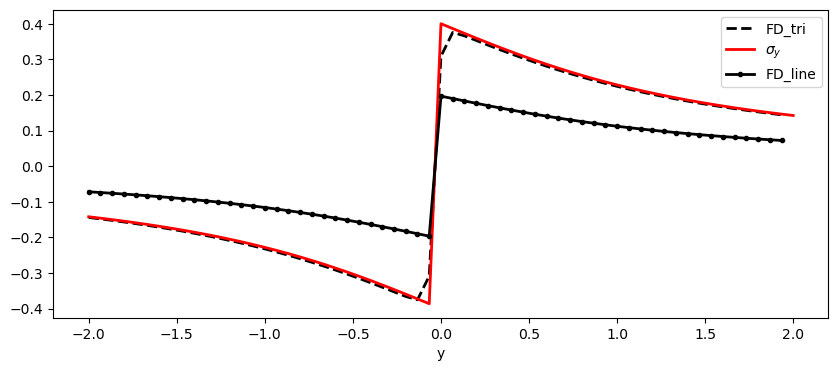

In [32]:
# sy_FD, sx_FD = np.gradient(u_vec[:, Nruns - 1].reshape(ny, nx), xvec, yvec)
sy_FD, sx_FD = np.gradient(u.reshape(ny, nx), yvec, xvec)
# sy_FD = u.reshape(ny, nx)

plt.figure(figsize=(10, 4))
plt.plot(
    y_obs.flatten()[plotindex][0:-1],
    np.diff(u_vec[plotindex, Nruns - 1]) / np.diff(yvec),
    "k--",
    linewidth=2,
    label="FD_tri",
)

plt.plot(
    y_obs.flatten()[plotindex], sy[plotindex], "r-", linewidth=2, label="$\sigma_y$"
)
plt.plot(
    y_obs.flatten()[plotindex][0:-1],
    np.diff(u[plotindex]) / np.diff(yvec),
    "k.-",
    linewidth=2,
    label="FD_line",
)
plt.xlabel("y")
plt.legend()
plt.show()